In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
'''dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)'''
data_dir = pathlib.Path('data/album_covers')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

29636


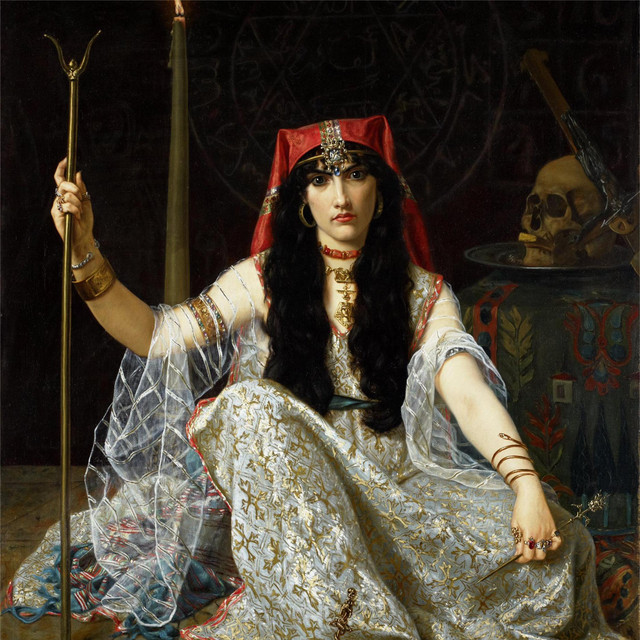

In [6]:
black_metal = list(data_dir.glob('black metal/*'))
PIL.Image.open(str(black_metal[-2]))

In [7]:
#training set
batch_size = 32
img_height = 640
img_width = 640

# Alternatively, specify a different encoding
train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="training",
    seed=13,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    follow_links=True,  # if symbolic links are involved
    label_mode='categorical',
    interpolation='bilinear',  # Specify interpolation method here
    shuffle=True,
    labels="inferred"
)

Found 29636 files belonging to 21 classes.
Using 23709 files for training.


In [8]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=13,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  follow_links=True,  # if symbolic links are involved
  label_mode='categorical',
  interpolation='bilinear',  # Specify interpolation method here
  shuffle=True,
  labels="inferred"
    )

Found 29636 files belonging to 21 classes.
Using 5927 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['black metal', 'blackgaze', 'death metal', 'deathcore', 'djent', 'doom metal', 'drone metal', 'folk metal', 'funeral doom', 'glam metal', 'goregrind', 'grindcore', 'industrial metal', 'metalcore', 'nu metal', 'nwobhm', 'power metal', 'progressive metal', 'sludge metal', 'symphonic metal', 'thrash metal']


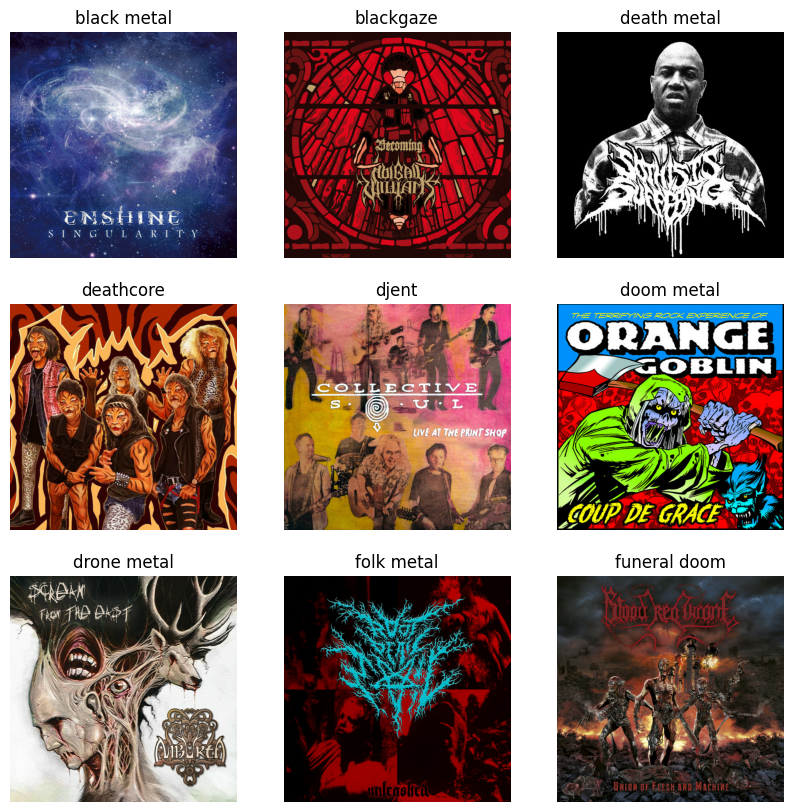

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    class_names = train_ds.class_names
    labels_np = labels.numpy()  # Convert labels tensor to numpy array
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[i])  # Index using numpy array
        plt.axis("off")
plt.show()


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# rescale colors
# RGB is from 0 to 255 => rescale from 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [13]:
# apply normalization layer to dataset using map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
# creating the model
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

c:\Users\MKnaepen\Documents\BeCode\projects\metal classifier\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Using sparse categorical crossentropy
              metrics=['accuracy'])

In [16]:
#summarize
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 640, 640, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 640, 640, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 320, 320, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 320, 320, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 160, 160, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 409600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    52,428,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,455,221 (200.10 MB)

 Trainable params: 52,455,221 (200.10 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
359/741 ━━━━━━━━━━━━━━━━━━━━ 10:49 2s/step - accuracy: 0.1344 - loss: 3.7244

: 

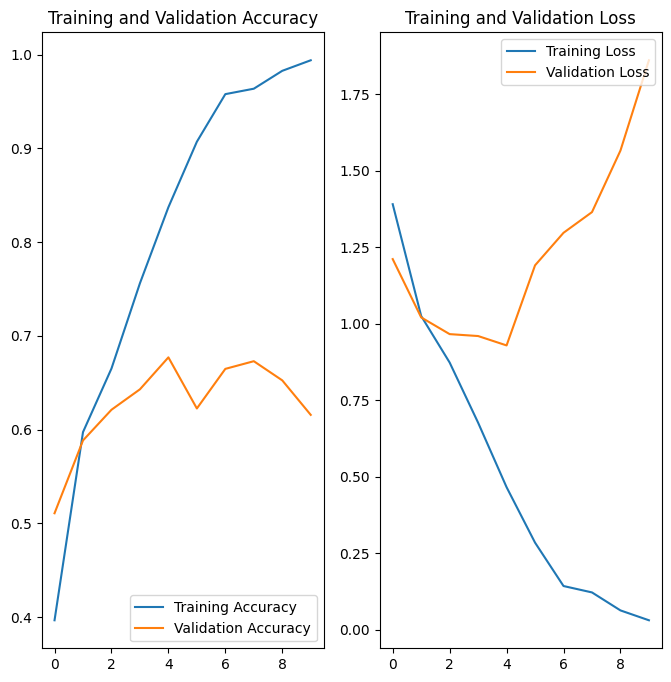

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
# data augmentation to fight overfitting
# randomly flipping, rotating or zooming on data to keep it believeable
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

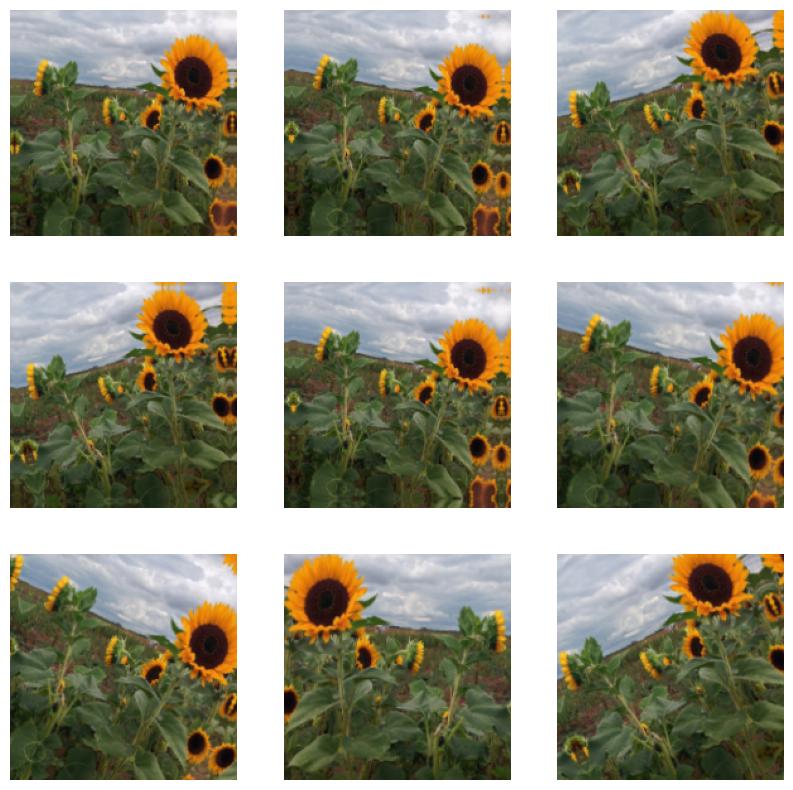

In [48]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [49]:
# data augmentation to fight overfitting
#dropout regularization drops a % of neurons to force the network to not rely on a particular neuron and learn more generalizable features

'''When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:'''

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [50]:
#retrain the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
#resummarize
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
#refit
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.2666 - loss: 1.7182 - val_accuracy: 0.5450 - val_loss: 1.1409
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.5338 - loss: 1.1256 - val_accuracy: 0.5981 - val_loss: 1.0253
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6252 - loss: 0.9617 - val_accuracy: 0.6213 - val_loss: 0.9583
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6534 - loss: 0.8899 - val_accuracy: 0.6703 - val_loss: 0.8483
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.6863 - loss: 0.8047 - val_accuracy: 0.6540 - val_loss: 0.9022
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7187 - loss: 0.7356 - val_accuracy: 0.6649 - val_loss: 0.8629
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.7258 - loss: 0.7226 - val_accuracy: 0.7044 - val_loss: 0.7883
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.7284 - loss: 0.6885 - val_accuracy: 0.6485

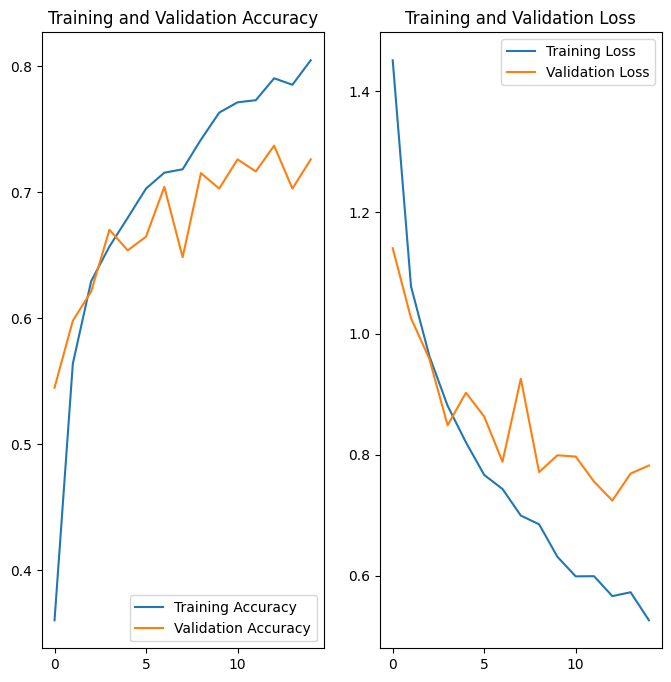

In [53]:
#visualize results again
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
#predict on new data
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
This image most likely belongs to sunflowers with a 95.49 percent confidence.


In [58]:
# converting from Keras Sequential model to TensorFlow Lite
# Convert the model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

AttributeError: 'Sequential' object has no attribute '_get_save_spec'